In [4]:
'''This is cs231 assignment3, training a good LSTM model using minpy'''

import time, os, json
import numpy as np
import matplotlib.pyplot as plt
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url
import minpy.numpy as mp
from minpy.core import convert_args, grad_and_loss, minpy_to_numpy
from cs231n.rnn_layers_minpy import *
from cs231n import optim_minpy as optim




class CaptioningRNN(object):
  """
  A CaptioningRNN produces captions from image features using a recurrent
  neural network.
  The RNN receives input vectors of size D, has a vocab size of V, works on
  sequences of length T, has an RNN hidden dimension of H, uses word vectors
  of dimension W, and operates on minibatches of size N.
  Note that we don't use any regularization for the CaptioningRNN.
  """
  
  def __init__(self, word_to_idx, input_dim=512, wordvec_dim=128,
               hidden_dim=128, cell_type='lstm', dtype=None):
    """
    Construct a new CaptioningRNN instance.
    Inputs:
    - word_to_idx: A dictionary giving the vocabulary. It contains V entries,
      and maps each string to a unique integer in the range [0, V).
    - input_dim: Dimension D of input image feature vectors.
    - wordvec_dim: Dimension W of word vectors.
    - hidden_dim: Dimension H for the hidden state of the RNN.
    - cell_type: What type of RNN to use; either 'rnn' or 'l#stm'.
    - dtype: numpy datatype to use; use float32 for training and float64 for
      numeric gradient checking.
    """
    if cell_type not in {'rnn', 'lstm'}:
      raise ValueError('Invalid cell_type "%s"' % cell_type)
    
    self.cell_type = cell_type
    self.dtype = dtype
    self.word_to_idx = word_to_idx
    self.idx_to_word = {i: w for w, i in word_to_idx.iteritems()}
    self.params = {}
    
    vocab_size = len(word_to_idx)

    self._null = word_to_idx['<NULL>']
    self._start = word_to_idx.get('<START>', None)
    self._end = word_to_idx.get('<END>', None)
    
    # Initialize word vectors
    self.params['W_embed'] = np.random.randn(vocab_size, wordvec_dim)
    self.params['W_embed'] /= 100
    
    # Initialize CNN -> hidden state projection parameters
    self.params['W_proj'] = np.random.randn(input_dim, hidden_dim)
    self.params['W_proj'] /= np.sqrt(input_dim)
    self.params['b_proj'] = np.zeros(hidden_dim)

    # Initialize parameters for the RNN
    dim_mul = {'lstm': 4, 'rnn': 1}[cell_type]
    self.params['Wx'] = np.random.randn(wordvec_dim, dim_mul * hidden_dim)
    self.params['Wx'] /= np.sqrt(wordvec_dim)
    self.params['Wh'] = np.random.randn(hidden_dim, dim_mul * hidden_dim)
    self.params['Wh'] /= np.sqrt(hidden_dim)
    self.params['b'] = np.zeros(dim_mul * hidden_dim)
    
    # Initialize output to vocab weights
    self.params['W_vocab'] = np.random.randn(hidden_dim, vocab_size)
    self.params['W_vocab'] /= np.sqrt(hidden_dim)
    self.params['b_vocab'] = np.zeros(vocab_size)
    
    # TODO: Support unified type casting among cpu and gpu
    # # Cast parameters to correct dtype
    # for k, v in self.params.iteritems():
    #   self.params[k] = v.astype(self.dtype)

  
  @convert_args
  def rnnNet(self, W_proj, b_proj, embed, Wx, Wh, b, W_vocab, b_vocab, features, 
             captions_in, captions_out, mask):
    # (1) Use an affine transformation to compute the initial hidden state     #
    #     from the image features. This should produce an array of shape (N, H)#
    h0 = affine_forward(features, W_proj, b_proj)
    # (2) Use a word embedding layer to transform the words in captions_in     #
    #     from indices to vectors, giving an array of shape (N, T, W).         #
    #embed = word_embedding_forward(captions_in, W_embed)
    # (3) Use either a vanilla RNN or LSTM (depending on self.cell_type) to    #
    #     process the sequence of input word vectors and produce hidden state  #
    #     vectors for all timesteps, producing an array of shape (N, T, H).    #
    if self.cell_type == 'rnn':
      rnn_out = rnn_forward(embed, h0, Wx, Wh, b)
    else:
      rnn_out = lstm_forward(embed, h0, Wx, Wh, b)
    # (4) Use a (temporal) affine transformation to compute scores over the    #
    #     vocabulary at every timestep using the hidden states, giving an      #
    #     array of shape (N, T, V).                                            #
    affine_out = temporal_affine_forward(rnn_out, W_vocab, b_vocab)
    # (5) Use (temporal) softmax to compute loss using captions_out, ignoring  #
    #     the points where the output word is <NULL> using the mask above.     #
    loss = temporal_softmax_loss(affine_out, captions_out, mask)

    return loss


  @convert_args
  def loss(self, features, captions):
    """
    Compute training-time loss for the RNN. We input image features and
    ground-truth captions for those images, and use an RNN (or LSTM) to compute
    loss and gradients on all parameters.
    
    Inputs:
    - features: Input image features, of shape (N, D)
    - captions: Ground-truth captions; an integer array of shape (N, T) where
      each element is in the range 0 <= y[i, t] < V
      
    Returns a tuple of:
    - loss: Scalar loss
    - grads: Dictionary of gradients parallel to self.params
    """
    # Cut captions into two pieces: captions_in has everything but the last word
    # and will be input to the RNN; captions_out has everything but the first
    # word and this is what we will expect the RNN to generate. These are offset
    # by one relative to each other because the RNN should produce word (t+1)
    # after receiving word t. The first element of captions_in will be the START
    # token, and the first element of captions_out will be the first word.
    captions_in = captions[:, :-1]
    captions_out = captions[:, 1:]

    # You'll need this 
    mask = (captions_out != self._null)

    # Weight and bias for the affine transform from image features to initial
    # hidden state
    W_proj, b_proj = self.params['W_proj'], self.params['b_proj']
    
    # Word embedding matrix
    W_embed = self.params['W_embed']
    
    # Input-to-hidden, hidden-to-hidden, and biases for the RNN
    Wx, Wh, b = self.params['Wx'], self.params['Wh'], self.params['b']

    # Weight and bias for the hidden-to-vocab transformation.
    W_vocab, b_vocab = self.params['W_vocab'], self.params['b_vocab']
    
    loss, grads = 0.0, {}
    
    embed = word_embedding_forward(captions_in, W_embed)
    
    grad_function = grad_and_loss(self.rnnNet, xrange(8))
    grad_array, loss = grad_function(W_proj, b_proj, embed, Wx, Wh, b, W_vocab, b_vocab,
                    features, captions_in, captions_out, mask) 
    
    #                                                                          #
    # In the backward pass you will need to compute the gradient of the loss   #
    # with respect to all model parameters. Use the loss and grads variables   #
    # defined above to store loss and gradients; grads[k] should give the      #
    # gradients for self.params[k]. 
    ''' 
    grads['W_proj'] = grad_array[0]
    grads['b_proj'] = grad_array[1]
    grads['W_embed'] = grad_array[2]
    grads['Wx'] = grad_array[3]
    grads['Wh'] = grad_array[4]
    grads['b'] = grad_array[5]
    grads['W_vocab'] = grad_array[6]
    grads['b_vocab'] = grad_array[7]
    '''

    grads['W_proj'] = grad_array[0]
    grads['b_proj'] = grad_array[1]
    grads['W_embed'] = word_embedding_backward(grad_array[2], captions_in, W_embed)
    grads['Wx'] = grad_array[3]
    grads['Wh'] = grad_array[4]
    grads['b'] = grad_array[5]
    grads['W_vocab'] = grad_array[6]
    grads['b_vocab'] = grad_array[7]
    
    return loss, grads


  def sample(self, features, max_length=30):
    """
    Run a test-time forward pass for the model, sampling captions for input
    feature vectors.
    At each timestep, we embed the current word, pass it and the previous hidden
    state to the RNN to get the next hidden state, use the hidden state to get
    scores for all vocab words, and choose the word with the highest score as
    the next word. The initial hidden state is computed by applying an affine
    transform to the input image features, and the initial word is the <START>
    token.
    For LSTMs you will also have to keep track of the cell state; in that case
    the initial cell state should be zero.
    Inputs:
    - features: Array of input image features of shape (N, D).
    - max_length: Maximum length T of generated captions.
    Returns:
    - captions: Array of shape (N, max_length) giving sampled captions,
      where each element is an integer in the range [0, V). The first element
      of captions should be the first sampled word, not the <START> token.
    """
    N = features.shape[0]
    #captions = self._null * np.ones((N, max_length), dtype=np.int32)
    captions = self._null * np.ones((N, max_length), dtype=int)

    # Unpack parameters
    W_proj, b_proj = self.params['W_proj'], self.params['b_proj']
    W_embed = self.params['W_embed']
    Wx, Wh, b = self.params['Wx'], self.params['Wh'], self.params['b']
    W_vocab, b_vocab = self.params['W_vocab'], self.params['b_vocab']
    
    h = affine_forward(features, W_proj, b_proj)

    if self.cell_type == 'lstm':
      c = np.zeros(h.shape)

    embed = self._start * np.ones(N, dtype=int)

    for t in xrange(max_length):
      # (1) Embed the previous word using the learned word embeddings
      embed = word_embedding_forward(embed, W_embed)
      # (2) Make an RNN / LSTM step using the previous hidden state and the
      #      embedded current word to get the next hidden state.
      if self.cell_type == 'rnn':
        h = rnn_step_forward(embed, h, Wx, Wh, b)
      else:
        h, c = lstm_step_forward(embed, h, c, Wx, Wh, b)
      # (3) Apply the learned affine transformation to the next hidden state to
      #     get scores for all words in the vocabulary
      out = affine_forward(h, W_vocab, b_vocab)

      # (4) Select the word with the highest score as the next word, writing it
      #     to the appropriate slot in the captions variable  
      #x = out.argmax(axis=1)
      embed = np.argmax(out, axis=1)

      captions[:, t] = embed
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    return captions


class CaptioningSolver(object):
  """
  A CaptioningSolver encapsulates all the logic necessary for training
  image captioning models. The CaptioningSolver performs stochastic gradient
  descent using different update rules defined in optim.py.
  The solver accepts both training and validataion data and labels so it can
  periodically check classification accuracy on both training and validation
  data to watch out for overfitting.
  To train a model, you will first construct a CaptioningSolver instance,
  passing the model, dataset, and various options (learning rate, batch size,
  etc) to the constructor. You will then call the train() method to run the 
  optimization procedure and train the model.
  
  After the train() method returns, model.params will contain the parameters
  that performed best on the validation set over the course of training.
  In addition, the instance variable solver.loss_history will contain a list
  of all losses encountered during training and the instance variables
  solver.train_acc_history and solver.val_acc_history will be lists containing
  the accuracies of the model on the training and validation set at each epoch.
  
  Example usage might look something like this:
  
  data = load_coco_data()
  model = MyAwesomeModel(hidden_dim=100)
  solver = CaptioningSolver(model, data,
                  update_rule='sgd',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  lr_decay=0.95,
                  num_epochs=10, batch_size=100,
                  print_every=100)
  solver.train()
  A CaptioningSolver works on a model object that must conform to the following
  API:
  - model.params must be a dictionary mapping string parameter names to numpy
    arrays containing parameter values.
  - model.loss(features, captions) must be a function that computes
    training-time loss and gradients, with the following inputs and outputs:
    Inputs:
    - features: Array giving a minibatch of features for images, of shape (N, D
    - captions: Array of captions for those images, of shape (N, T) where
      each element is in the range (0, V].
    Returns:
    - loss: Scalar giving the loss
    - grads: Dictionary with the same keys as self.params mapping parameter
      names to gradients of the loss with respect to those parameters.
  """

  def __init__(self, model, data, **kwargs):
    """
    Construct a new CaptioningSolver instance.
    
    Required arguments:
    - model: A model object conforming to the API described above
    - data: A dictionary of training and validation data from load_coco_data
    Optional arguments:
    - update_rule: A string giving the name of an update rule in optim.py.
      Default is 'sgd'.
    - optim_config: A dictionary containing hyperparameters that will be
      passed to the chosen update rule. Each update rule requires different
      hyperparameters (see optim.py) but all update rules require a
      'learning_rate' parameter so that should always be present.
    - lr_decay: A scalar for learning rate decay; after each epoch the learning
      rate is multiplied by this value.
    - batch_size: Size of minibatches used to compute loss and gradient during
      training.
    - num_epochs: The number of epochs to run for during training.
    - print_every: Integer; training losses will be printed every print_every
      iterations.
    - verbose: Boolean; if set to false then no output will be printed during
      training.
    """
    self.model = model
    self.data = data
    
    # Unpack keyword arguments
    self.update_rule = kwargs.pop('update_rule', 'sgd')
    self.optim_config = kwargs.pop('optim_config', {})
    self.lr_decay = kwargs.pop('lr_decay', 1.0)
    self.batch_size = kwargs.pop('batch_size', 100)
    self.num_epochs = kwargs.pop('num_epochs', 10)

    self.print_every = kwargs.pop('print_every', 10)
    self.verbose = kwargs.pop('verbose', True)

    # Throw an error if there are extra keyword arguments
    if len(kwargs) > 0:
      extra = ', '.join('"%s"' % k for k in kwargs.keys())
      raise ValueError('Unrecognized arguments %s' % extra)

    # Make sure the update rule exists, then replace the string
    # name with the actual function
    if not hasattr(optim, self.update_rule):
      raise ValueError('Invalid update_rule "%s"' % self.update_rule)
    self.update_rule = getattr(optim, self.update_rule)

    self._reset()


  def _reset(self):
    """
    Set up some book-keeping variables for optimization. Don't call this
    manually.
    """
    # Set up some variables for book-keeping
    self.epoch = 0
    self.best_val_acc = 0
    self.best_params = {}
    self.loss_history = []
    self.train_acc_history = []
    self.val_acc_history = []

    # Make a deep copy of the optim_config for each parameter
    self.optim_configs = {}
    for p in self.model.params:
      d = {k: v for k, v in self.optim_config.iteritems()}
      self.optim_configs[p] = d


  def _step(self):
    """
    Make a single gradient update. This is called by train() and should not
    be called manually.
    """
    # Make a minibatch of training data
    minibatch = sample_coco_minibatch(self.data,
                  batch_size=self.batch_size,
                  split='train')
    captions, features, urls = minibatch

    # Compute loss and gradient
    loss, grads = self.model.loss(features, captions)
    self.loss_history.append(loss)

    # Perform a parameter update
    for p, w in self.model.params.iteritems():
      dw = grads[p]
      config = self.optim_configs[p]
      next_w, next_config = self.update_rule(w, dw, config)
      self.model.params[p] = next_w
      self.optim_configs[p] = next_config

  def train(self):
    """
    Run optimization to train the model.
    """
    num_train = self.data['train_captions'].shape[0]
    iterations_per_epoch = max(num_train / self.batch_size, 1)
    num_iterations = self.num_epochs * iterations_per_epoch

    for t in xrange(num_iterations):
      self._step()

      # Maybe print training loss
      if self.verbose and t % self.print_every == 0:
        print '(Iteration %d / %d) loss: %f' % (
               t + 1, num_iterations, self.loss_history[-1])

      # At the end of every epoch, increment the epoch counter and decay the
      # learning rate.
      epoch_end = (t + 1) % iterations_per_epoch == 0
      if epoch_end:
        self.epoch += 1
        for k in self.optim_configs:
          self.optim_configs[k]['learning_rate'] *= self.lr_decay

      # Check train and val accuracy on the first iteration, the last
      # iteration, and at the end of each epoch.
      # TODO: Implement some logic to check Bleu on validation set periodically

    # At the end of training swap the best params into the model
# self.model.params = self.best_params



(Iteration 1 / 50) loss: 77.001593
(Iteration 11 / 50) loss: 52.761694
(Iteration 21 / 50) loss: 45.125194
(Iteration 31 / 50) loss: 41.723929
(Iteration 41 / 50) loss: 36.397100
Time Elapsed: 126.74593401


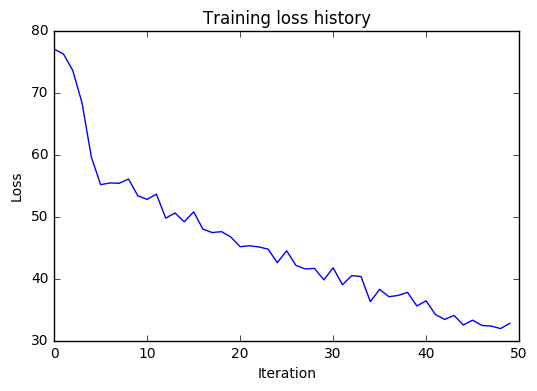

In [5]:

hidden_dim = 512
wordvec_dim = 256
max_train = 1280
learning_rate = 5e-3
batch_size = 128
num_epochs = 5

data = load_coco_data(max_train=max_train)
lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

lstm_solver = CaptioningSolver(lstm_model, data,
           update_rule='adam',
           num_epochs=num_epochs,
           batch_size=batch_size,
           optim_config={
             'learning_rate': learning_rate,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )
import time
start = time.time()
lstm_solver.train()
end = time.time()
print 'Time Elapsed:', end - start

# Plot the training losses
plt.plot(lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

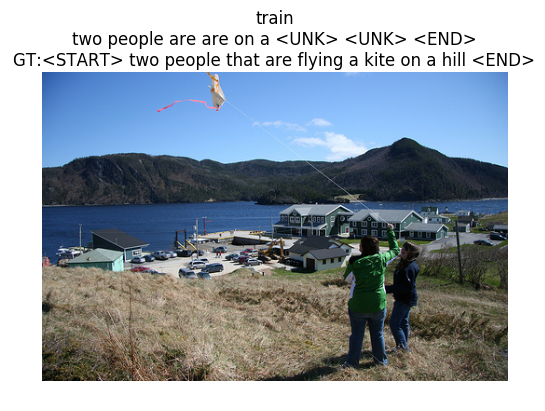

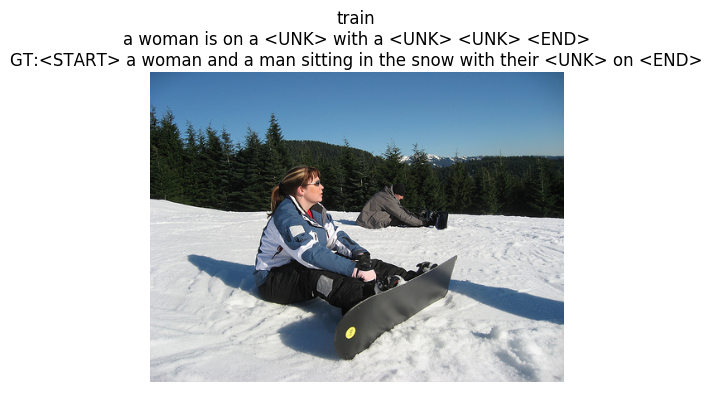

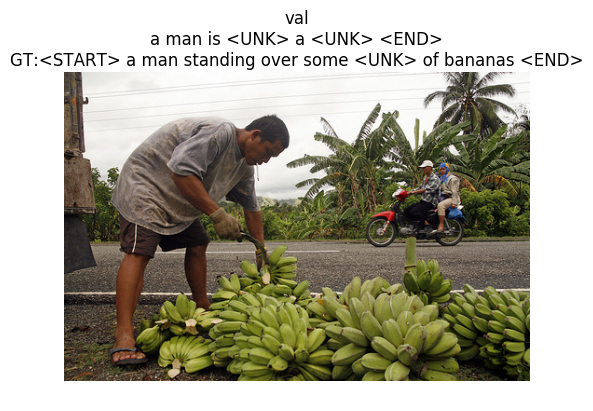

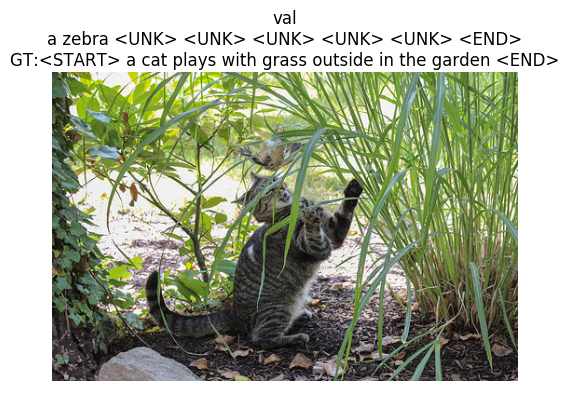

In [6]:


for split in ['train', 'val']:
  minibatch = sample_coco_minibatch(data, split=split, batch_size=2)
  gt_captions, features, urls = minibatch
  gt_captions = decode_captions(gt_captions, data['idx_to_word'])

  sample_captions = minpy_to_numpy(lstm_model.sample(features))
  sample_captions = decode_captions(sample_captions, data['idx_to_word'])
  for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
    plt.imshow(image_from_url(url))
    plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
    plt.axis('off')
    plt.show()

